# Load datasets and build one dataset by language

**Datasets:**
1. New round-2 completions (what we have labelled)
2. Old round-1 completions (what we have labelled)
3. Collected from telegram channels (we've collected channels for topics and downloaded posts)
4. Telegram provided labels from r-1 (true labels from round-1 for en and ru)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('../..')


In [3]:
from src.train.predict import load_test_file

## Data prep

In [4]:
COMPLETIONS_R2 = [
    'data/raw/r-2/completions/project-1-at-2021-04-20-16-16-72cac916.json',
    'data/raw/r-2/completions/project-1-current.json',
]

COMPLETIONS_R1 = [
    'data/raw/r-1/completions/2020-02-14_completions.json',
    'data/raw/r-1/completions/2020-02-14_active_completions.json',
]

TG_DOWNLOADS = {
        'META': 'data/raw/r-1/downloads/meta.csv',
        'POSTS': 'data/raw/r-1/downloads/posts.csv',
        'TOPICS': 'data/external/telegram_channels.csv'
    }

TG_TRUE_LABELS = [
    {
        'lang_code': 'en',
        'input': 'data/external/r-1/submission1489/category_en/input.txt',
        'output': 'data/external/r-1/submission1489/category_en/tg_output.txt'
    },
    {
        'lang_code': 'ru',
        'input': 'data/external/r-1/submission1489/category_ru/input.txt',
        'output': 'data/external/r-1/submission1489/category_ru/tg_output.txt'
    },
]

PRIMARY2SECONDARY = 3

In [5]:
def calc_topic_weights(primary, secondary):
    """ create a weight dict from topics """
    total = len(primary) * PRIMARY2SECONDARY + len(secondary)
    weights = {p: PRIMARY2SECONDARY / total for p in primary}
    weights.update({s: 1 / total for s in secondary})
    return weights


def get_topics(value):
    """ return a list of topics from one string topic or multiple from a dict """
    if isinstance(value, dict):
        topics = value['choices']
    else:
        topics = [value] if value != '' else []
    return topics


def raise_non_existent(file):
    raise Exception(f'{file} does not exist')


def load_labelled_data(files):
    if len(files) == 0:
        return pd.DataFrame()
    for f in files:
        if not os.path.exists(f):
            raise_non_existent(f)
    labelled_data = [pd.read_json(c,) for c in files]
    labelled_data = pd.concat(labelled_data)
    labelled_data['secondary'].fillna('', inplace=True)
    labelled_data['primary'] = labelled_data['primary'].apply(get_topics)
    labelled_data['secondary'] = labelled_data['secondary'].apply(get_topics)
    labelled_data['category'] = labelled_data.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), axis=1)
    labelled_data.drop([
        'primary','secondary', # encoded into `category`
        'subscribers', 'counters', # for now
        'annotator', 'annotation_id', 'title_display', 'description_display', 'recent_posts_display', # from new completions
        "predictions", "score", "posts", # old completions
    ], axis=1, inplace=True, errors='ignore')
    labelled_data.info()
    return labelled_data


def prepare_text(row):
    """ extract and merge all text from a channel """
    post_texts = '\n'.join([
        post.get('text', "") 
        if isinstance(post, dict) else post
        for post in row['recent_posts']
    ])
    merged = '\n'.join([row['title'], row['description'], post_texts])
    return merged

def show_lang_stats(data):
    lang_counts = data['lang_code'].value_counts()
    c = Counter()
    _ = [c.update(cat) for cat in data['category']]
    c = pd.DataFrame(c.most_common(len(c)), columns=['topic','score'])
    fig,axes = plt.subplots(1, 2, figsize=(15,7))
    sns.barplot(x=lang_counts, y=lang_counts.index, ax=axes[1]);
    sns.barplot(x=c['score'],y=c['topic'], ax=axes[0] );

### Load

#### New completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 648
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         659 non-null    object
 1   description   659 non-null    object
 2   recent_posts  659 non-null    object
 3   lang_code     659 non-null    object
 4   id            659 non-null    int64 
 5   category      659 non-null    object
dtypes: int64(1), object(5)
memory usage: 36.0+ KB


,title,description,recent_posts,lang_code,id,category,subset
14,أستغفرالله لي ولوٌالدِي🖇.,اللهم اجعل شوقي لاامي والى ابي ولااخي اجراًً ي...,"[{'type': 'text', 'text': 'اللهُم ارزقني حظ ال...",ar,756,{'Religion & Spirituality': 1.0},r-2
114,Monplus_bigsize,#bigsize#buyukbeden\n\nmerkez mah. Sıpahı sok....,"[{'type': 'text', 'text': 'Buyuk beden elbise ...",uz,616,"{'Offers & Promotions': 0.75, 'Fashion & Beaut...",r-2
412,اقفوبكك,تغانمو الوصّل دام الارواح حيه⚚‏\n شمال ...,"[{'type': 'text', 'text': 'قناة [الخمّايل] الم...",ar,271,"{'Motivation & Self-development': 0.5, 'Art & ...",r-2
481,🌸دلتنگ کربلا 🌸,السلام علیک یا اباعبدالله الحسین 🖤\n\n••---••-...,"[{'type': 'video', 'text': 'تصویری ؛ کلیپ 🔹قب...",fa,196,{'Religion & Spirituality': 1.0},r-2


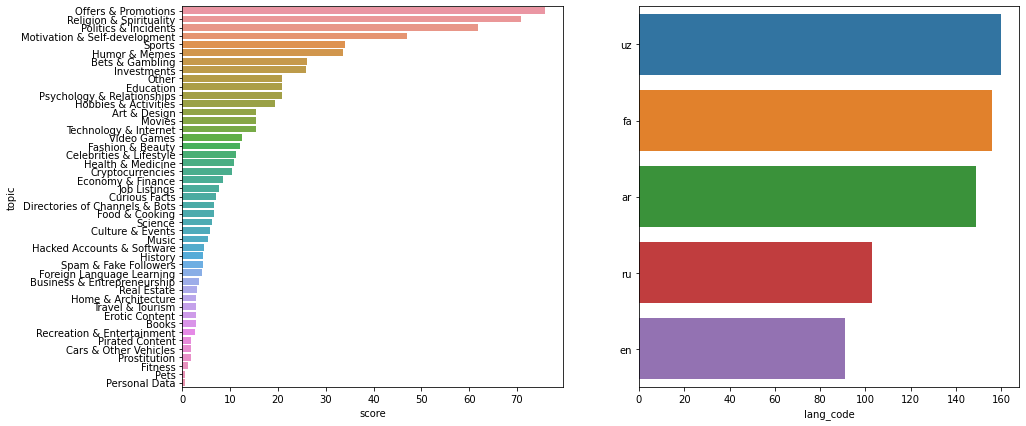

In [18]:
new_labels = load_labelled_data(COMPLETIONS_R2)
new_labels['subset'] = 'r-2'

show_lang_stats(new_labels)

new_labels.sample(4)


#### Old completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 282
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   691 non-null    object
 1   lang_code     691 non-null    object
 2   recent_posts  691 non-null    object
 3   title         691 non-null    object
 4   id            691 non-null    int64 
 5   category      691 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.8+ KB


,description,lang_code,recent_posts,title,id,category,subset
198,Life & Executive Coach \nВаш персональный лайф...,ru,[​​Подготовка ко #днювлюбленных с Международны...,Ваш коуч,359,{'Other': 1.0},r-1
276,,en,[Free Dating App & Flirt Chat - Match with Sin...,Apps & Games,291,"{'Technology & Internet': 0.5, 'Video Games': ...",r-1
175,🔰🔰FREE SYTHETIC & FOREX SIGNALS🔰 \nPREMIUM GRO...,en,[After \nGet 20% off our mentorship \n$80 \nOn...,BLUEPIP FOREX,708,{'Investments': 1.0},r-1


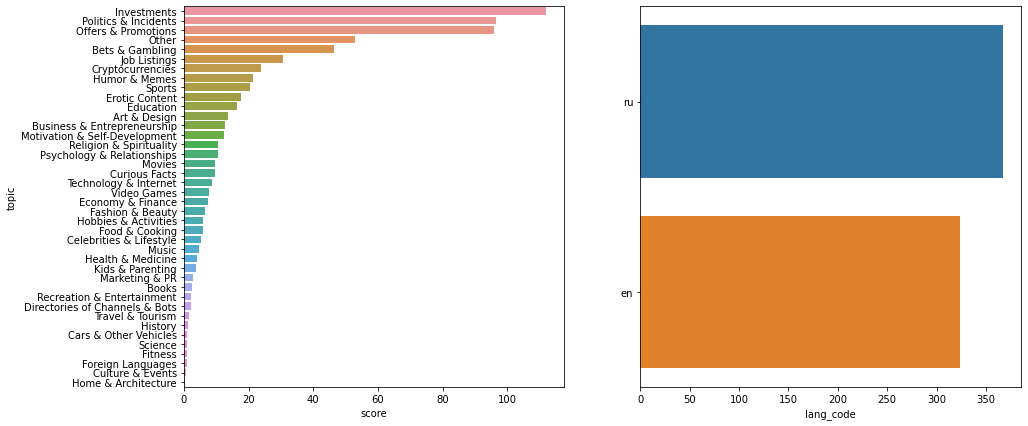

In [19]:
old_labels = load_labelled_data(COMPLETIONS_R1)
old_labels['subset'] = 'r-1'


show_lang_stats(old_labels)

old_labels.sample(3)


#### Tg channel downloads

In [20]:
posts = pd.read_csv(TG_DOWNLOADS['POSTS'])
meta = pd.read_csv(TG_DOWNLOADS['META'])
topics = pd.read_csv(TG_DOWNLOADS['TOPICS'])

# clean
topics['topic [Secondary]'].fillna("", inplace=True)
posts['message'].fillna("", inplace=True)
meta['about'].fillna("", inplace=True)

# new cols
topics['username'] = topics['link'].apply(lambda x: x.split('/')[-1])
topics['lang_code'] = topics['language'].apply(lambda x: x.lower()[:2])

# rename
posts.rename({'channel':'username', 'message': 'recent_posts'}, axis=1, inplace=True)
meta.rename({'about':'description',}, axis=1, inplace=True)

# calculate topic weights
topics['primary'] = topics['topic [Primary]'].apply(lambda x: x.split(','))
topics['secondary'] = topics['topic [Secondary]'].apply(lambda x: x.split(',') if x != '' else [])
topics['category'] = topics.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), 
                               axis=1)

# group recent posts
posts = posts.groupby('username', as_index=False).agg({'recent_posts': lambda row: list(x for x in row if x != '')})


# merge
tg_downloads = topics[['username','lang_code','category']]\
            .merge(meta, on=['username'])\
            .merge(posts, on='username')
tg_downloads['subset'] = 'chan'


del tg_downloads['username']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 0 to 530
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lang_code     531 non-null    object
 1   category      531 non-null    object
 2   title         531 non-null    object
 3   description   531 non-null    object
 4   recent_posts  531 non-null    object
 5   subset        531 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


,lang_code,category,title,description,recent_posts,subset
119,ru,{'Job Listings': 1.0},Workplace | Вакансии | Фриланс,Топовый агрегатор вакансий и заданий для фрила...,[​​Требуется ведущий (менеджер) телеграм канал...,chan
338,en,"{'Fashion & Beauty': 0.5, ' Offers & Promotion...",Luxury Replicas (DHGate),+ Daily update.\n+ High quality copies.\n+ Onl...,[📌 Bag “Louis Vuitton”\n\n👉 Order: https://fas...,chan
524,ru,"{'Technology & Internet': 0.75, 'Business & En...",Золото Бородача,"Блог 10х инженера. Запуск IT проектов, размышл...","[Немного уточню: я пытаюсь понять не то, как б...",chan
215,ru,{'Kids & Parenting': 1.0},Дети | Воспитание | Психология,По вопросам рекламы обращайтесь к @Reklama_Kri...,"[ОТ ПРИРОДЫ С ЛЮБОВЬЮ 🌳❤\n\nВы можете сказать,...",chan


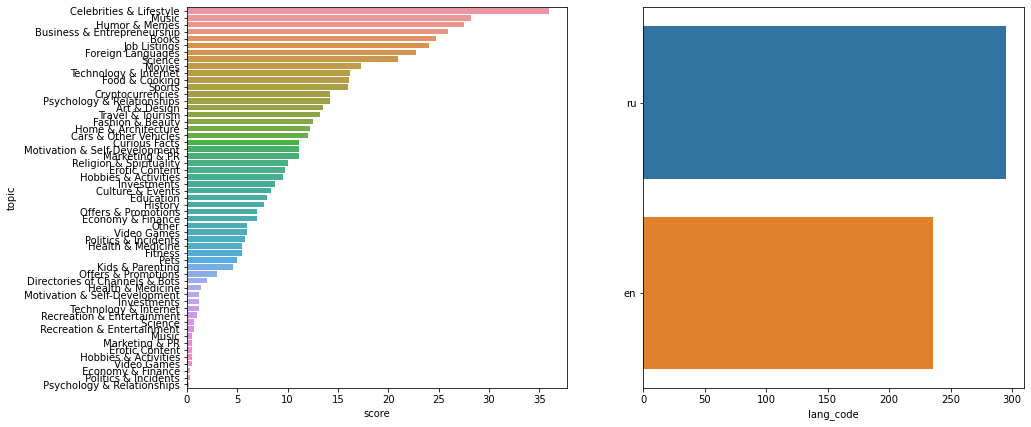

In [21]:
tg_downloads.info()

show_lang_stats(tg_downloads)

tg_downloads.sample(4)


#### Tg true labels

In [22]:
def update_dict(src_dict,dest_dict):
    src_dict.update(dest_dict)
    return src_dict

In [24]:
tg_true = []

for files in TG_TRUE_LABELS:
    inp = load_test_file(files['input'])
    out = load_test_file(files['output'])
    tg_true.extend([update_dict(i, o) for i,o in zip(inp, out)])

    
tg_true = pd.DataFrame(tg_true)

tg_true['subset'] = 'tg'

Loaded 14775 rows
Loaded 14775 rows
Loaded 16726 rows
Loaded 16726 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31501 entries, 0 to 31500
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         31501 non-null  object
 1   description   31501 non-null  object
 2   recent_posts  31501 non-null  object
 3   lang_code     31501 non-null  object
 4   category      31501 non-null  object
 5   subset        31501 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


,title,description,recent_posts,lang_code,category,subset
28609,Магнит [50%] бот - Канал,ээ,"[Завтра вернем старые цены, Распродажа!\n\nЛюб...",ru,{'Offers & Promotions': 1},tg
28325,Аналитика От Чехова,Автор не несет ответственность за действия под...,[Рынок решил развернутся. Наблюдайте за техами...,ru,"{'Investments': 0.57142857142857, 'Politics & ...",tg
29933,Блог врача - акушера,Саша Микерина.\nЖиву на два города - Сочи и Спб,"[кто не успел или потерял😂, Лена всем передаёт...",ru,"{'Health & Medicine': 0.57142857142857, 'Other...",tg


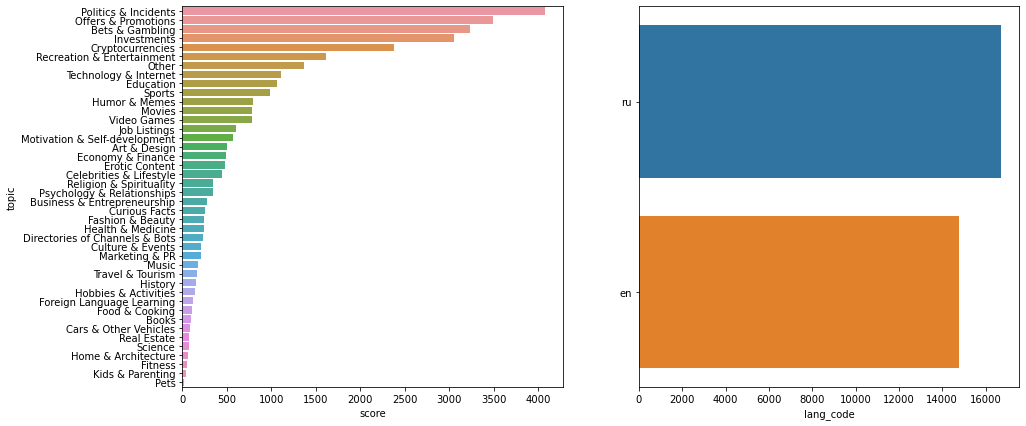

In [25]:
tg_true.info()

show_lang_stats(tg_true)

tg_true.sample(3)

## Combine and save

### concat

In [26]:
comb = pd.concat([
    new_labels,
    old_labels,
    tg_downloads,
    tg_true,

], axis=0)
comb.shape

(33382, 7)

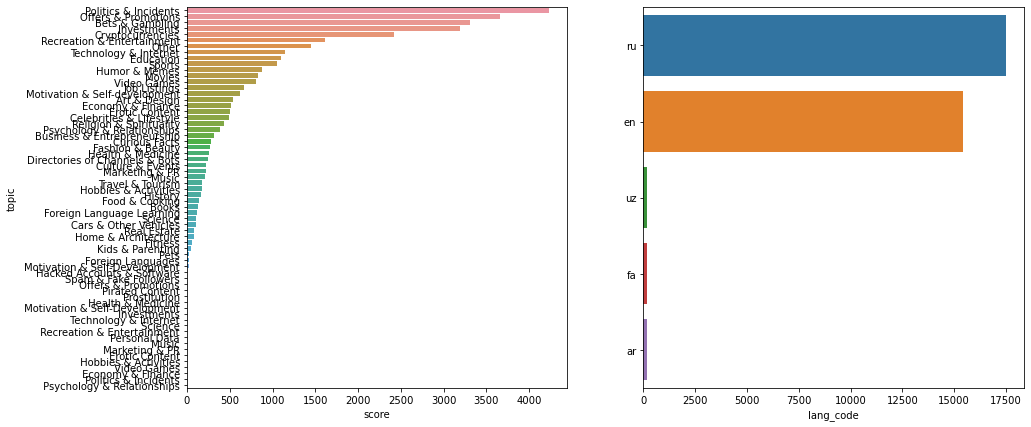

In [27]:
show_lang_stats(comb)

In [28]:
comb['subset'].value_counts()

tg      31501
r-1       691
r-2       659
chan      531
Name: subset, dtype: int64

### get raw texts

In [29]:
comb['text'] = comb.apply(prepare_text, axis=1)

### Save

In [30]:
comb.to_csv('data/interim/train_data.csv', index=False)